# AKARI-NEP master catalogue
## Preparation of Pan-STARRS1 - 3pi Steradian Survey (3SS) data

This catalogue comes from `dmu0_PanSTARRS1-3SS`.

In the catalogue, we keep:

- The `uniquePspsSTid` as unique object identifier;
- The r-band position which is given for all the sources;
- The grizy `<band>ApMag` aperture magnitude (see below);
- The grizy `<band>KronMag` as total magnitude.

The Pan-STARRS1-3SS catalogue provides for each band an aperture magnitude defined as “In PS1, an 'optimal' aperture radius is determined based on the local PSF. The wings of the same analytic PSF are then used to extrapolate the flux measured inside this aperture to a 'total' flux.”

The observations used for the catalogue where done between 2010 and 2015 ([ref](https://confluence.stsci.edu/display/PANSTARRS/PS1+Image+data+products)).

**TODO**: Check if the detection flag can be used to know in which bands an object was detected to construct the coverage maps.

**TODO**: Check for stellarity.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
91cdb7b (Fri Oct 20 11:48:11 2017 +0100) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "ps1_ra"
DEC_COL = "ps1_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        "objID": "ps1_id",
        "raMean": "ps1_ra",
        "decMean": "ps1_dec",
        "gApMag": "m_ap_gpc1_g",
        "gApMagErr": "merr_ap_gpc1_g",
        "gKronMag": "m_gpc1_g",
        "gKronMagErr": "merr_gpc1_g",
        "rApMag": "m_ap_gpc1_r",
        "rApMagErr": "merr_ap_gpc1_r",
        "rKronMag": "m_gpc1_r",
        "rKronMagErr": "merr_gpc1_r",
        "iApMag": "m_ap_gpc1_i",
        "iApMagErr": "merr_ap_gpc1_i",
        "iKronMag": "m_gpc1_i",
        "iKronMagErr": "merr_gpc1_i",
        "zApMag": "m_ap_gpc1_z",
        "zApMagErr": "merr_ap_gpc1_z",
        "zKronMag": "m_gpc1_z",
        "zKronMagErr": "merr_gpc1_z",
        "yApMag": "m_ap_gpc1_y",
        "yApMagErr": "merr_ap_gpc1_y",
        "yKronMag": "m_gpc1_y",
        "yKronMagErr": "merr_gpc1_y"
    })


catalogue = Table.read("../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_AKARI-NEP.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2012

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        # -999 is used for missing values
        catalogue[col][catalogue[col] < -900] = np.nan
        catalogue[errcol][catalogue[errcol] < -900] = np.nan     
        
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [6]:
catalogue[:10].show_in_notebook()

idx,ps1_id,ps1_ra,ps1_dec,m_ap_gpc1_g,merr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_r,merr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_i,merr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_z,merr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_y,merr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,f_ap_gpc1_g,ferr_ap_gpc1_g,f_gpc1_g,ferr_gpc1_g,flag_gpc1_g,f_ap_gpc1_r,ferr_ap_gpc1_r,f_gpc1_r,ferr_gpc1_r,flag_gpc1_r,f_ap_gpc1_i,ferr_ap_gpc1_i,f_gpc1_i,ferr_gpc1_i,flag_gpc1_i,f_ap_gpc1_z,ferr_ap_gpc1_z,f_gpc1_z,ferr_gpc1_z,flag_gpc1_z,f_ap_gpc1_y,ferr_ap_gpc1_y,f_gpc1_y,ferr_gpc1_y,flag_gpc1_y
0,185492687458386376,268.74577492,64.57968015,21.9046001434,0.0101520000026,22.0480003357,0.0811270028353,21.0527992249,0.00458300020546,21.1956996918,0.0421530008316,20.8341007233,0.00299700000323,20.9587993622,0.0375219993293,20.470199585,0.00555399991572,20.6145992279,0.063073001802,20.2996997833,0.00436800019816,20.4615001678,0.130457997322,6.28289703691,0.0587472080743,5.50553928262,0.411377919455,False,13.7682996739,0.0581173584871,12.0703572238,0.468623755812,False,16.8406833756,0.0464859953182,15.0134414672,0.518850102072,False,23.5461640783,0.120448588463,20.6139068315,1.19751093961,False,27.549903798,0.110835380382,23.7355846076,2.85197897943,False
1,185492688435933420,268.84354621,64.57723582,18.1965007782,0.00184000004083,18.273399353,0.0029349999968,17.7474994659,0.0010000000475,17.8185997009,0.00234699994326,17.5769004822,0.000668999971822,17.6481990814,0.00213299994357,17.5377006531,0.00143900001422,17.6198997498,0.00542700011283,17.5501003265,0.0012309999438,17.6704006195,0.0124310003594,191.16117386,0.323961350985,178.090297249,0.481419906202,False,289.068130425,0.266241599836,270.744797152,0.585260048222,False,338.25155915,0.208421053428,316.752730585,0.622281502175,False,350.68705808,0.464789402205,325.117315345,1.62508323783,False,346.704812007,0.39309143623,310.3414266,3.55321519968,False
2,185492687854425344,268.78555563,64.5787738,23.0165996552,0.0169420000166,23.2094993591,0.191829994321,21.5863990784,0.00585999991745,21.6653995514,0.0641350001097,20.8250999451,0.00298499991186,nan,nan,20.6418991089,0.00601099990308,20.7786006927,0.0756139978766,20.1804008484,0.00413399981335,20.2597007751,0.148977994919,2.25610931136,0.0352046876791,1.8888621164,0.333727849798,False,8.42248737481,0.045458349003,7.83141393361,0.462605678331,False,16.9808733156,0.0466852861018,nan,nan,False,20.1020503503,0.111291695145,17.7239176248,1.23434796019,False,30.7496134477,0.11708083022,28.5837819322,3.92208945487,False
3,185492688278625547,268.82784315,64.57891553,23.1634998322,0.0181280001998,23.3740997314,0.19209100306,22.5205001831,0.00901000015438,22.6763000488,0.144675001502,21.4232006073,0.00393099989742,21.4979991913,0.0750420019031,21.2441005707,0.00793099962175,21.2780990601,0.155677005649,21.5487003326,0.00776399997994,nan,nan,1.97060720863,0.0329022535264,1.62315542426,0.287172475416,False,3.56286959318,0.029566533237,3.08659736053,0.411290952456,False,9.78858140887,0.0354403881399,9.1369305425,0.63151026571,False,11.5440918018,0.0843263652002,11.1882039871,1.60420743793,False,8.72006790611,0.0623564054984,nan,nan,False
4,185492689587156643,268.95866733,64.57994654,22.5578994751,0.0137149998918,21.9804992676,0.102687999606,21.7000999451,0.00617500022054,21.7959003448,0.083370000124,20.7502002716,0.00288400007412,20.815700531,0.0383879989386,20.574300766,0.00582600012422,20.6679992676,0.0695540010929,20.6284999847,0.00508200004697,20.7542991638,0.170348003507,3.44223257342,0.0434822189453,5.85868695276,0.554109590212,False,7.58507749046,0.0431392588468,6.94448208791,0.533243222426,False,18.1936523307,0.0483271115397,17.1285179683,0.60560707721,False,21.3933941973,0.114795764113,19.6245764802,1.25718181633,False,20.3516678497,0.0952599503588,18.1250967918,2.84376079412,False
5,185492687869214984,268.78690441,64.57852791,23.3985004425,0.0201990008354,nan,nan,22.1312007904,0.00753099983558,nan,nan,21.7663993835,0.00460499990731,21.7926998138,0.069241002202,21.08180

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['merr_ap_gpc1_r', 'merr_ap_gpc1_g', 'merr_ap_gpc1_i', 'merr_ap_gpc1_z', 'merr_ap_gpc1_y']
FLAG_NAME = 'ps1_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL,  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 292409 sources.
The cleaned catalogue has 222011 sources (70398 removed).
The cleaned catalogue has 59288 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_AKARI-NEP.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

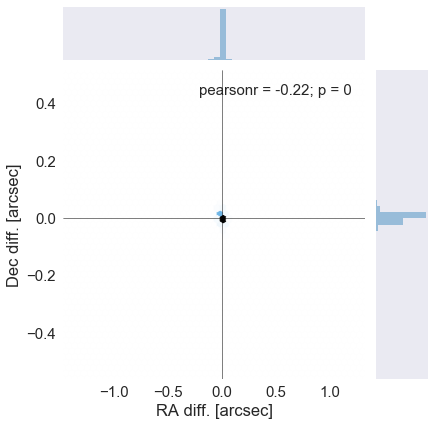

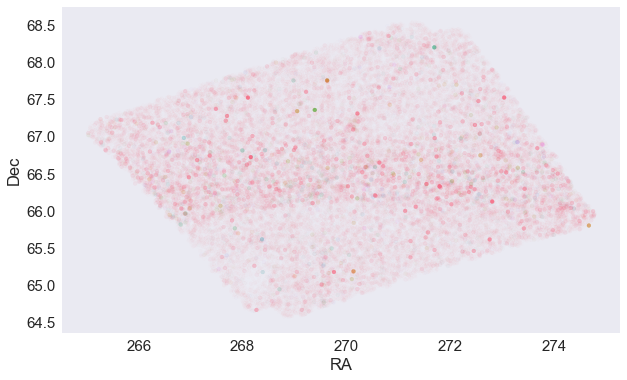

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.0002913838898166432 arcsec
Dec correction: -0.0013614236905823418 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

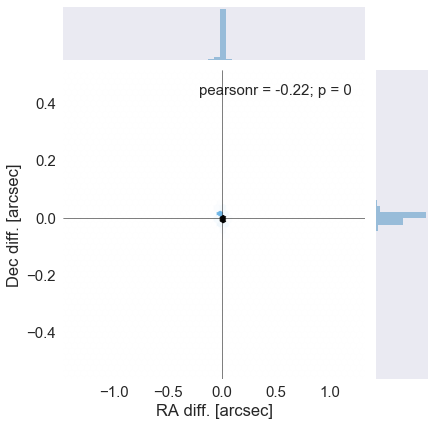

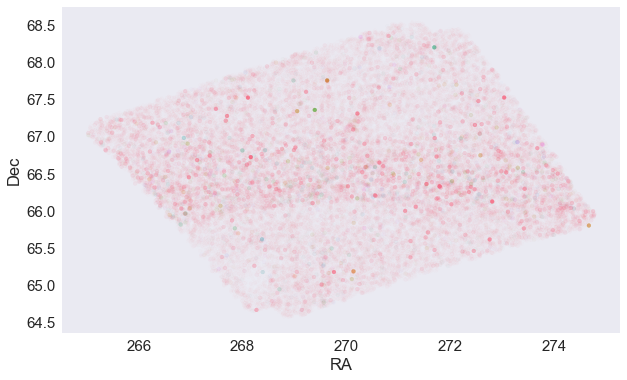

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "ps1_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

62198 sources flagged.


# V - Saving to disk

In [15]:
catalogue.write("{}/PS1.fits".format(OUT_DIR), overwrite=True)